In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense,Activation

import datetime


data = pd.read_csv('035720.KS.csv') # 카카오 주식데이터 불러오기
data = data.dropna(axis=0) # 결측치 제거
print(data.head()) # 

high_prices = data['High'].values  # 고가
low_prices = data['Low'].values # 저가 
mid_prices = (high_prices + low_prices) / 2  #평균가

#print(high_prices)


seq_len = 50 # 50개의 데이터를 이용해 > 다음을 예측
sequence_length = seq_len + 1 # 그렇기때문에 51크기의 윈도우


result = [] 

for index in range(len(mid_prices) - sequence_length): # 윈도우가 1칸씩 넘어가면서 만들어짐
                                                       # 예) 8월 1일부터 50개 8월2일부터 50개 ...
    result.append(mid_prices[index:index+ sequence_length])
    
print(np.array(result))


normalized_data = [] 

for window in result:  # 현재일 - 전일 -1 을해서 정규화 
    normalized_window = [((float(p)/float(window[0]))-1) for p in window]
    normalized_data.append(normalized_window)
    

#print(normalized_data)

result = np.array(normalized_data)

print(result.shape)

row = int(round(result.shape[0] * 0.9))
train = result[:row , :]  # train 데이터는 9할의 자료
np.random.shuffle(train) # shuffling

x_train = train[:,:-1] # train 51개의 데이터중 앞선 50개의 데이터
print(x_train.shape)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
print(x_train.shape)
y_train = train[:,-1] # train 의 51개중의 데이터중 마지막 데이터 51번째데이터

x_test = result[row:,:-1] # 나머지 10%의 데이터로 테스트셋 구성
print(x_test.shape[0],x_test.shape[1])
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
y_test = result[row:,-1]

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)


model = Sequential() # 모델생성

model.add(LSTM(50,return_sequences=True, input_shape=(50,1)))  #순환신경망을 사용 앞의 50개 feature의 값을 사용해
model.add(LSTM(64,return_sequences=False))                    #마지막 label을 예측해냄
model.add(Dense(1,activation='relu'))
model.compile(loss='mse', optimizer='adam') # 오차함수는 수치 예측 값이기 때문에 mean squared error 

print(model.summary()) # 모델의 구조 확인

model.fit(x_train,y_train,
          validation_data=(x_test,y_test),
          batch_size=10,
          epochs=3) # train data 를 fitting함



         Date      Open      High       Low     Close      Adj Close  \
0  2015-11-30  126500.0  131000.0  119400.0  120600.0  120038.468750   
1  2015-12-01  120800.0  121700.0  118300.0  119400.0  118844.054688   
2  2015-12-02  121400.0  123600.0  119800.0  119800.0  119242.195313   
3  2015-12-03  116300.0  121100.0  116300.0  120800.0  120237.539063   
4  2015-12-04  119300.0  121300.0  118300.0  118300.0  117749.179688   

      Volume  
0  2931459.0  
1   631065.0  
2   602515.0  
3   540467.0  
4   291835.0  
[[125200. 120000. 121700. ...  96550.  92800.  94100.]
 [120000. 121700. 118700. ...  92800.  94100.  93600.]
 [121700. 118700. 119800. ...  94100.  93600.  93450.]
 ...
 [383500. 390250. 379750. ... 365000. 367000. 371750.]
 [390250. 379750. 373500. ... 367000. 371750. 371750.]
 [379750. 373500. 377000. ... 371750. 371750. 370500.]]
(1169, 51)
(1052, 50)
(1052, 50, 1)
117 50
(1052, 50, 1) (117, 50, 1) (1052,) (117,)
Model: "sequential"
____________________________________

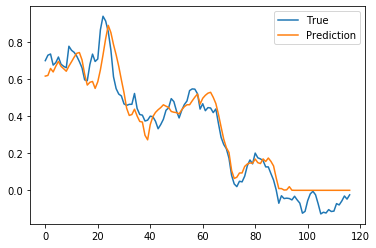

In [3]:
pred = model.predict(x_test) # x_test 의 결과 > 현재 모델링을 한 예측

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test,label='True') # 실제 그래프
ax.plot(pred,label='Prediction') # 예측 그래프 
ax.legend()
plt.show()